In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)


Mounted at /content/drive


In [2]:
# install syft
!pip install syft==0.2.9

     |████████████████████████████████| 440kB 10.3MB/s 
     |████████████████████████████████| 450kB 20.7MB/s 
     |████████████████████████████████| 2.0MB 33.0MB/s 
     |████████████████████████████████| 491kB 62.2MB/s 
     |████████████████████████████████| 20.1MB 427kB/s 
     |████████████████████████████████| 204kB 66.8MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 753.4MB 19kB/s 
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 133kB 42.2MB/s 
     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 1.8MB 48.0MB/s 
     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 4.0MB 44.2MB/s 
     |████████████████████████████████| 9.0MB 29.5MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 3.2MB 30.4MB/s 
    

In [3]:
# install private set intersection 
# to encrypt raw data
!pip install openmined.psi

     |████████████████████████████████| 1.9MB 12.6MB/s 


In [4]:
import tensorflow as tf
import sys

# import the module from google drive
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
import src


import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor

import syft as sy

hook = sy.TorchHook(torch)

In [5]:
from src.dataloader import VerticalDataLoader
from src.psi.util import Client, Server
from src.utils.split_data import add_ids

In [6]:
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
from uuid import uuid4

import numpy as np
import pandas as pd

import time
import matplotlib.pyplot as plt

In [8]:
# load the data
df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/dataset_b_all.csv")

In [9]:
# clean the data
# transform into binary columns

df = df.dropna()
df = pd.get_dummies(df)
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head()

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Loan Purpose_Birth Giving,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Funeral Expenses,Loan Purpose_Investment,Loan Purpose_Marriage,Loan Purpose_Medical Expenses,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Loan Purpose_Traveling,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,...,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Civil Servant,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Not Applicable,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_All Other,Nature of Business_Construction Trades,Nature of Business_Driver,Nature of Business_Executive,Nature of Business_Factory Worker,Nature of Business_Guard,Nature of Business_Homemaker,Nature of Business_Manager,Nature of Business_No Response,Nature of Business_Office Worker,Nature of Business_Owner of a Business,Nature of Business_Professional,Nature of Business_Retired,Nature of Business_Sales,Nature of Business_Semi Professional,Nature of Business_Services,Nature of Business_Skilled Worker,Nature of Business_Student,Nature of Business_Unemployed,Nature of Business_Unskilled Worker,Job Position_Government/Semi-Government,Job Position_Homemaker,Job Position_No Response,Job Position_Private,Job Position_Public,Job Position_Retired,Job Position_Self Employed,Job Position_Student,Job Position_Unemployed,Indicators
0,60000,24,22.301,0.0,10245.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,100000,60,33.159,0.0,10000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,50000,24,28.389,2000.0,9700.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,70000,36,35.573,1200.0,23000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,300000,60,30.849,11000.0,34000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
# split it into training and testing dataset
train, test = train_test_split( df , test_size=0.3, random_state=42)

In [11]:
# transform into tensor data
train_features = torch.as_tensor(train.drop("Indicators", axis=1).to_numpy()) # can only from numpy to tensor
train_target = torch.as_tensor(train["Indicators"].to_numpy())

In [12]:
# transform into tensor data
test_features = torch.as_tensor(train.drop("Indicators", axis=1).to_numpy()) # can only from numpy to tensor
test_target = torch.as_tensor(train["Indicators"].to_numpy())

In [13]:
# Implements a vertical dataset with TensorDataset
import torch
from torch.utils.data import Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [14]:
# self-designed VerticalTensorDataset
# to add id, set features and target

class VerticalTensorDataset(Dataset):
    def __init__(self, features, targets):
        super().__init__()

        self.data = features
        self.targets = targets
        self.size = features.shape[0]

        self.ids = np.array([uuid4() for _ in range(len(self))])

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        if self.data is None:
          data = None
        else:
          data = self.data[index]
        if self.targets is None:
          target = None
        else:
          target = self.targets[index]

        id = self.ids[index]

        return (*filter(lambda x: x is not None, (data, target, id)),)

    def get_ids(self):
        return [str(id) for id in self.ids]
    


In [15]:
# put training data into VerticalTensorDataset 
# to add ids and identify features and target column
train_dataset = VerticalTensorDataset(train_features, train_target)

print(train_dataset[0])
# VerticalDataLoader is from PyVertical package
# it vetically patitions the data
train_dataloader = VerticalDataLoader(train_dataset, batch_size = 64) 

(tensor([6.0000e+04, 2.4000e+01, 4.4797e+01, 6.5500e+02, 1.9570e+04, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e

In [16]:
# apply on testing data
test_dataset = VerticalTensorDataset(test_features, test_target)

print(test_dataset[0])

test_dataloader = VerticalDataLoader(test_dataset, batch_size = 1)

(tensor([6.0000e+04, 2.4000e+01, 4.4797e+01, 6.5500e+02, 1.9570e+04, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e

In [17]:
# SplitNN
# assign model segments to each local nodes
# define how gradient is sent
class SplitNN:
    def __init__(self, models, optimizers):
        self.models = models
        self.optimizers = optimizers

        self.data = []
        self.remote_tensors = []

    def forward(self, x):
        data = []
        remote_tensors = []

        data.append(self.models[0](x))

        if data[-1].location == self.models[1].location:
            remote_tensors.append(data[-1].detach().requires_grad_())
        else:
            remote_tensors.append(
                data[-1].detach().move(self.models[1].location).requires_grad_()
            )

        i = 1
        while i < (len(models) - 1):
            data.append(self.models[i](remote_tensors[-1]))

            if data[-1].location == self.models[i + 1].location:
                remote_tensors.append(data[-1].detach().requires_grad_())
            else:
                remote_tensors.append(
                    data[-1].detach().move(self.models[i + 1].location).requires_grad_()
                )

            i += 1

        data.append(self.models[i](remote_tensors[-1]))

        self.data = data
        self.remote_tensors = remote_tensors

        return data[-1]
        
    def backward(self):
        for i in range(len(models) - 2, -1, -1):
            if self.remote_tensors[i].location == self.data[i].location:
                grads = self.remote_tensors[i].grad.copy()
            else:
                grads = self.remote_tensors[i].grad.copy().move(self.data[i].location)
    
            self.data[i].backward(grads)

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()

    def step(self):
        for opt in self.optimizers:
            opt.step()

In [18]:
torch.manual_seed(3)

# Define our model segments

input_size = 83
hidden_sizes = [32, 64]
output_size = 1


# Deep Learning model
# to apply it in SplitNN framework, it is divided into 2 parts
models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[0]),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_sizes[1]),
        nn.Dropout(p=0.1)
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size))

]
'''
models = [
    nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Dropout(p=0.1)
    ),
    nn.Sequential(nn.Linear(hidden_sizes[1], output_size))

]
'''
# create optimisers for each segment and link to them
optimizers = [
    optim.SGD(model.parameters(), lr=0.001)
    for model in models
]


In [19]:
# create virtual workers as local node simulation
alice = sy.VirtualWorker(hook, id="alice")
bob = sy.VirtualWorker(hook, id="bob")

# send Model Segments to model locations
model_locations = [alice, bob]
for model, location in zip(models, model_locations):
    model.send(location)

# instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = SplitNN(models, optimizers)

In [20]:
def train(x, target, splitNN):
    
    #1) Zero our grads
    splitNN.zero_grads()
    
    #2) Make a prediction
    pred = splitNN.forward(x)
    
    #3) Figure out how much we missed by
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(pred.reshape(-1), target.to(torch.float))
    
    #4) Backprop the loss on the end layer
    loss.backward()
    
    #5) Feed Gradients backward through the nework
    splitNN.backward()
    
    #6) Change the weights
    splitNN.step()
    
    return loss, pred

In [21]:
epochs = 200

In [22]:
e_loss = []
e_acc = []
timelist = []

In [23]:
for i in range(epochs):
    running_loss = 0
    correct_preds = 0
    total_preds = 0
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()

    for (data, ids1), (labels, ids2) in train_dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = train(data.float(), labels, splitNN)
        
        # Convert predictions
        preds_ = preds.get().squeeze(1)
        labels_ = labels.get()
        preds_match = ((torch.sigmoid(preds_) > 0.5) == labels_)
        #print(non_exist)

        # Collect statistics
        running_loss += loss.get()
        correct_preds = correct_preds + int(preds_match.sum())
        total_preds = total_preds + int(preds_match.size()[0])

    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append((running_loss/len(train_dataloader)).item()) # for plt
    e_acc.append((100*correct_preds/total_preds)) # for plt

    print(f"Epoch {i} - Training loss: {running_loss/len(train_dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

Epoch 0 - Training loss: 0.713 - Accuracy: 50.233
Epoch 1 - Training loss: 0.706 - Accuracy: 51.005
Epoch 2 - Training loss: 0.706 - Accuracy: 50.539
Epoch 3 - Training loss: 0.705 - Accuracy: 50.257
Epoch 4 - Training loss: 0.704 - Accuracy: 50.784
Epoch 5 - Training loss: 0.703 - Accuracy: 50.306
Epoch 6 - Training loss: 0.700 - Accuracy: 51.458
Epoch 7 - Training loss: 0.699 - Accuracy: 51.115
Epoch 8 - Training loss: 0.698 - Accuracy: 51.973
Epoch 9 - Training loss: 0.697 - Accuracy: 51.617
Epoch 10 - Training loss: 0.698 - Accuracy: 51.691
Epoch 11 - Training loss: 0.696 - Accuracy: 52.083
Epoch 12 - Training loss: 0.697 - Accuracy: 51.862
Epoch 13 - Training loss: 0.694 - Accuracy: 52.328
Epoch 14 - Training loss: 0.695 - Accuracy: 51.985
Epoch 15 - Training loss: 0.696 - Accuracy: 52.450
Epoch 16 - Training loss: 0.695 - Accuracy: 51.887
Epoch 17 - Training loss: 0.693 - Accuracy: 52.855
Epoch 18 - Training loss: 0.694 - Accuracy: 52.475
Epoch 19 - Training loss: 0.694 - Accurac

In [24]:
preds_match

tensor([ True, False,  True, False, False, False, False, False,  True, False,
         True,  True,  True,  True, False, False,  True, False, False, False,
         True,  True, False, False,  True, False,  True, False, False, False,
         True,  True, False, False])

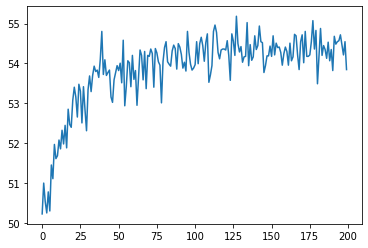

In [25]:
plt.plot(e_acc)

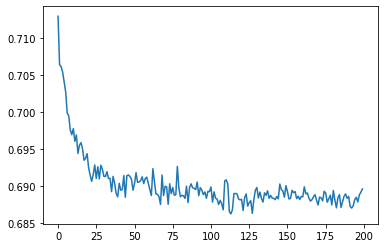

In [26]:
plt.plot(e_loss)

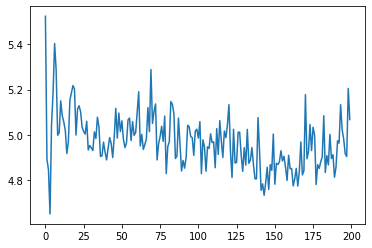

In [27]:
plt.plot(timelist)

In [28]:
import statistics
x = statistics.mean(timelist)
print(x)

4.969311761856079


In [29]:
# define test to apply trained model
def test(x, target, splitNN):
       
    #1) Make a prediction
    pred = splitNN.forward(x)
    
    #2) Figure out how much we missed by
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(pred.reshape(-1), target.to(torch.float))
        
    return loss, pred

In [30]:
y_pred_list = []
y_target_list = []
running_loss = 0
correct_preds = 0
total_preds = 0

# lock the models
models[0].eval()
models[1].eval()

# put testing data into the models

with torch.no_grad():
    for (data, ids1), (labels, ids2) in test_dataloader:
        # Train a model
        data = data.send(models[0].location)
        data = data.view(data.shape[0], -1)
        labels = labels.send(models[-1].location)

        # Call model
        loss, preds = test(data.float(), labels, splitNN)
        
        # Convert predictions
        preds_ = preds.get().squeeze(1)
        labels_ = labels.get()
        preds_match = ((torch.sigmoid(preds_) > 0.5) == labels_)
        y_pred_list.append(torch.sigmoid(preds_) > 0.5)
        y_target_list.append(labels_)

        # Collect statistics
        running_loss += loss.get()
        correct_preds = correct_preds + int(preds_match.sum())
        total_preds = total_preds + int(preds_match.size()[0])


    print(f" Testing loss: {running_loss/len(test_dataloader):.3f} - Accuracy: {100*correct_preds/total_preds:.3f}")

 Testing loss: 0.696 - Accuracy: 53.602


In [31]:
confusion_matrix(y_target_list, y_pred_list)

array([[4298,   80],
       [3707,   77]])

In [32]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.54      0.98      0.69      4378
           1       0.49      0.02      0.04      3784

    accuracy                           0.54      8162
   macro avg       0.51      0.50      0.37      8162
weighted avg       0.52      0.54      0.39      8162

